In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import contextily as ctx

# These are the unedited, imported methods from orbit_plot.py
from asp_plot.orbit_plot import read_positions_rotations, read_angles

## Methods for extraction and plotting

In [2]:
def reproject_ecef(positions, to_epsg=4326):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{to_epsg}")
    x, y, z = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((x, y, z))

In [3]:
def get_orbit_plot_gdf(original_camera, optimized_camera, map_crs):
    # orbit_plot.py method to get angles in NED
    #  https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L412
    #
    #  This method already calls read_positions_rotations below, but it 
    #  doesn't return the positions and rotations we want for plotting
    original_rotation_angles, optimized_rotation_angles = read_angles([original_camera], [optimized_camera], [])

    # orbit_plot.py method to get positions and rotations
    #  https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L381
    #  
    #  Could be retrieved from the above method, by adding to return statement there
    original_positions, original_rotations = read_positions_rotations([original_camera])
    optimized_positions, optimized_rotations = read_positions_rotations([optimized_camera])

    # Taken directly from orbit_plot.py
    #  https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L600-L607
    #  "The order is roll, pitch, yaw, as returned by R.from_matrix().as_euler('XYZ',degrees=True)"
    original_roll   = [r[0] for r in original_rotation_angles]
    original_pitch  = [r[1] for r in original_rotation_angles]
    original_yaw    = [r[2] for r in original_rotation_angles]
    optimized_roll  = [r[0] for r in optimized_rotation_angles]
    optimized_pitch = [r[1] for r in optimized_rotation_angles]
    optimized_yaw   = [r[2] for r in optimized_rotation_angles]

    # We are interested in the difference between the original and optimized angles
    roll_diff = np.array(original_roll) - np.array(optimized_roll)
    pitch_diff = np.array(original_pitch) - np.array(optimized_pitch)
    yaw_diff = np.array(original_yaw) - np.array(optimized_yaw)

    # Reproject positions from ECEF to map_crs
    original_positions = reproject_ecef(np.array(original_positions), to_epsg=map_crs)
    optimized_positions = reproject_ecef(np.array(optimized_positions), to_epsg=map_crs)

    # Calculate the difference between the original and optimized positions
    position_diffs = optimized_positions - original_positions
    x_position_diff = position_diffs[:, 0]
    y_position_diff = position_diffs[:, 1]
    z_position_diff = position_diffs[:, 2]
    position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

    # Build a GeoDataFrame for plotting
    data = {
        "original_positions": [Point(x, y, z) for x, y, z in original_positions],
        "optimized_positions": [Point(x, y, z) for x, y, z in optimized_positions],
        "original_rotations": [r for r in original_rotations],
        "optimized_rotations": [r for r in optimized_rotations],
        "position_diff_magnitude": position_diff_magnitudes,
        "x_position_diff": x_position_diff,
        "y_position_diff": y_position_diff,
        "z_position_diff": z_position_diff,
        "original_roll": original_roll,
        "original_pitch": original_pitch,
        "original_yaw": original_yaw,
        "optimized_roll": optimized_roll,
        "optimized_pitch": optimized_pitch,
        "optimized_yaw": optimized_yaw,
        "roll_diff": roll_diff,
        "pitch_diff": pitch_diff,
        "yaw_diff": yaw_diff,
    }
    df = pd.DataFrame(data)
    gdf = gpd.GeoDataFrame(df, geometry="original_positions")
    gdf.set_crs(epsg=map_crs, inplace=True);
    return gdf


In [4]:
def mapview_original_optimized_angles(gdf, title=None, figsize=(15, 5), **ctx_kwargs):
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    gdf.plot(column="original_roll", cmap="viridis", markersize=50, legend=True, ax=axes[0])
    axes[0].set_title("Original Roll (deg)")
    ctx.add_basemap(ax=axes[0], **ctx_kwargs)

    gdf.plot(column="original_pitch", cmap="viridis", markersize=50, legend=True, ax=axes[1])
    axes[1].set_title("Original Pitch, (deg)")
    ctx.add_basemap(ax=axes[1], **ctx_kwargs)

    gdf.plot(column="original_yaw", cmap="viridis", markersize=50, legend=True, ax=axes[2])
    axes[2].set_title("Original Yaw (deg)")
    ctx.add_basemap(ax=axes[2], **ctx_kwargs)

    gdf.plot(column="optimized_roll", cmap="viridis", markersize=50, legend=True, ax=axes[3])
    axes[3].set_title("Optimized Roll (deg)")
    ctx.add_basemap(ax=axes[3], **ctx_kwargs)

    gdf.plot(column="optimized_pitch", cmap="viridis", markersize=50, legend=True, ax=axes[4])
    axes[4].set_title("Optimized Pitch, (deg)")
    ctx.add_basemap(ax=axes[4], **ctx_kwargs)

    gdf.plot(column="optimized_yaw", cmap="viridis", markersize=50, legend=True, ax=axes[5])
    axes[5].set_title("Optimized Yaw (deg)")
    ctx.add_basemap(ax=axes[5], **ctx_kwargs)

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def mapview_difference_in_positions_and_angles(gdf, title=None, figsize=(15, 5), **ctx_kwargs):
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    x_vmax = max(abs(np.percentile(gdf.x_position_diff, 1)), abs(np.percentile(gdf.x_position_diff, 99)))
    y_vmax = max(abs(np.percentile(gdf.y_position_diff, 1)), abs(np.percentile(gdf.y_position_diff, 99)))
    z_vmax = max(abs(np.percentile(gdf.z_position_diff, 1)), abs(np.percentile(gdf.z_position_diff, 99)))
    roll_vmax = max(abs(np.percentile(gdf.roll_diff, 1)), abs(np.percentile(gdf.roll_diff, 99)))
    pitch_vmax = max(abs(np.percentile(gdf.pitch_diff, 1)), abs(np.percentile(gdf.pitch_diff, 99)))
    yaw_vmax = max(abs(np.percentile(gdf.yaw_diff, 1)), abs(np.percentile(gdf.yaw_diff, 99)))

    gdf.plot(column="x_position_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[0], vmin=-x_vmax, vmax=x_vmax)
    axes[0].set_title("Difference in X position [Easting] (m)")
    ctx.add_basemap(ax=axes[0], **ctx_kwargs)

    gdf.plot(column="y_position_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[1], vmin=-y_vmax, vmax=y_vmax)
    axes[1].set_title("Difference in Y position [Northing] (m)")
    ctx.add_basemap(ax=axes[1], **ctx_kwargs)

    gdf.plot(column="z_position_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[2], vmin=-z_vmax, vmax=z_vmax)
    axes[2].set_title("Difference in Z position [Altitude] (m)")
    ctx.add_basemap(ax=axes[2], **ctx_kwargs)

    gdf.plot(column="roll_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[3], vmin=-roll_vmax, vmax=roll_vmax)
    axes[3].set_title("Difference in Roll (deg)")
    ctx.add_basemap(ax=axes[3], **ctx_kwargs)

    gdf.plot(column="pitch_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[4], vmin=-pitch_vmax, vmax=pitch_vmax)
    axes[4].set_title("Difference in Pitch (deg)")
    ctx.add_basemap(ax=axes[4], **ctx_kwargs)

    gdf.plot(column="yaw_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[5], vmin=-yaw_vmax, vmax=yaw_vmax)
    axes[5].set_title("Difference in Yaw (deg)")
    ctx.add_basemap(ax=axes[5], **ctx_kwargs)

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_difference_in_positions_and_angles(gdf, title=None):
    frame = np.arange(gdf.shape[0])

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Plot differences in x, y, z
    axes[0].plot(frame, gdf.x_position_diff)
    axes[0].set_title("Difference in X position [Easting] (m)")
    axes[0].set_xlabel("Frame Index")
    axes[0].set_ylabel("Difference (m)")

    axes[1].plot(frame, gdf.y_position_diff)
    axes[1].set_title("Difference in Y position [Northing] (m)")
    axes[1].set_xlabel("Frame Index")
    axes[1].set_ylabel("Difference (m)")

    axes[2].plot(frame, gdf.z_position_diff)
    axes[2].set_title("Difference in Z position [Altitude] (m)")
    axes[2].set_xlabel("Frame Index")
    axes[2].set_ylabel("Difference (m)")

    # Plot differences in roll, pitch, yaw
    axes[3].plot(frame, gdf.roll_diff)
    axes[3].set_title("Difference in Roll (deg)")
    axes[3].set_xlabel("Frame Index")
    axes[3].set_ylabel("Roll Difference (deg)")

    axes[4].plot(frame, gdf.pitch_diff)
    axes[4].set_title("Difference in Pitch (deg)")
    axes[4].set_xlabel("Frame Index")
    axes[4].set_ylabel("Pitch Difference (deg)")

    axes[5].plot(frame, gdf.yaw_diff)
    axes[5].set_title("Difference in Yaw (deg)")
    axes[5].set_xlabel("Frame Index")
    axes[5].set_ylabel("Yaw Difference (deg)")

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

## Jitter optimization for Antarctica

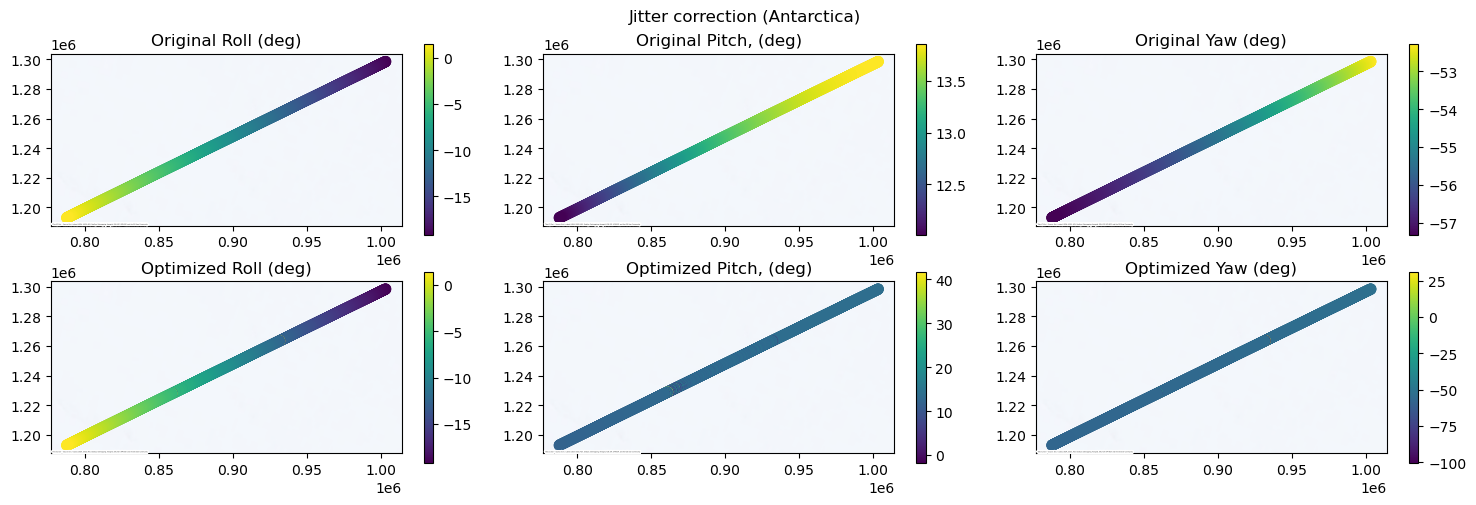

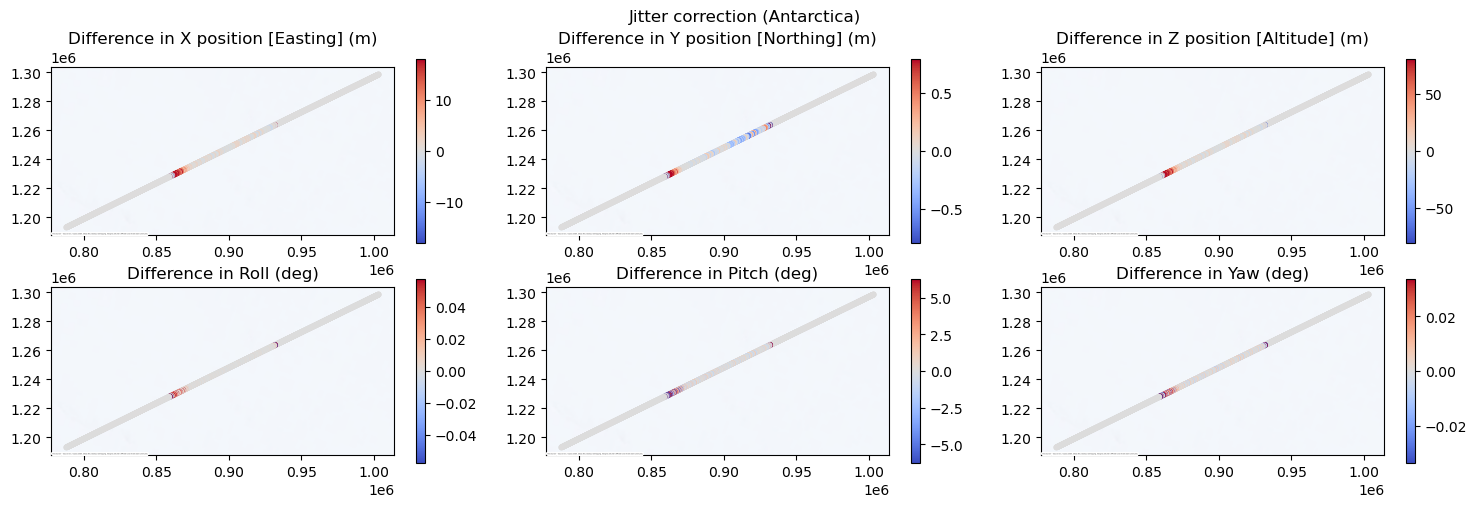

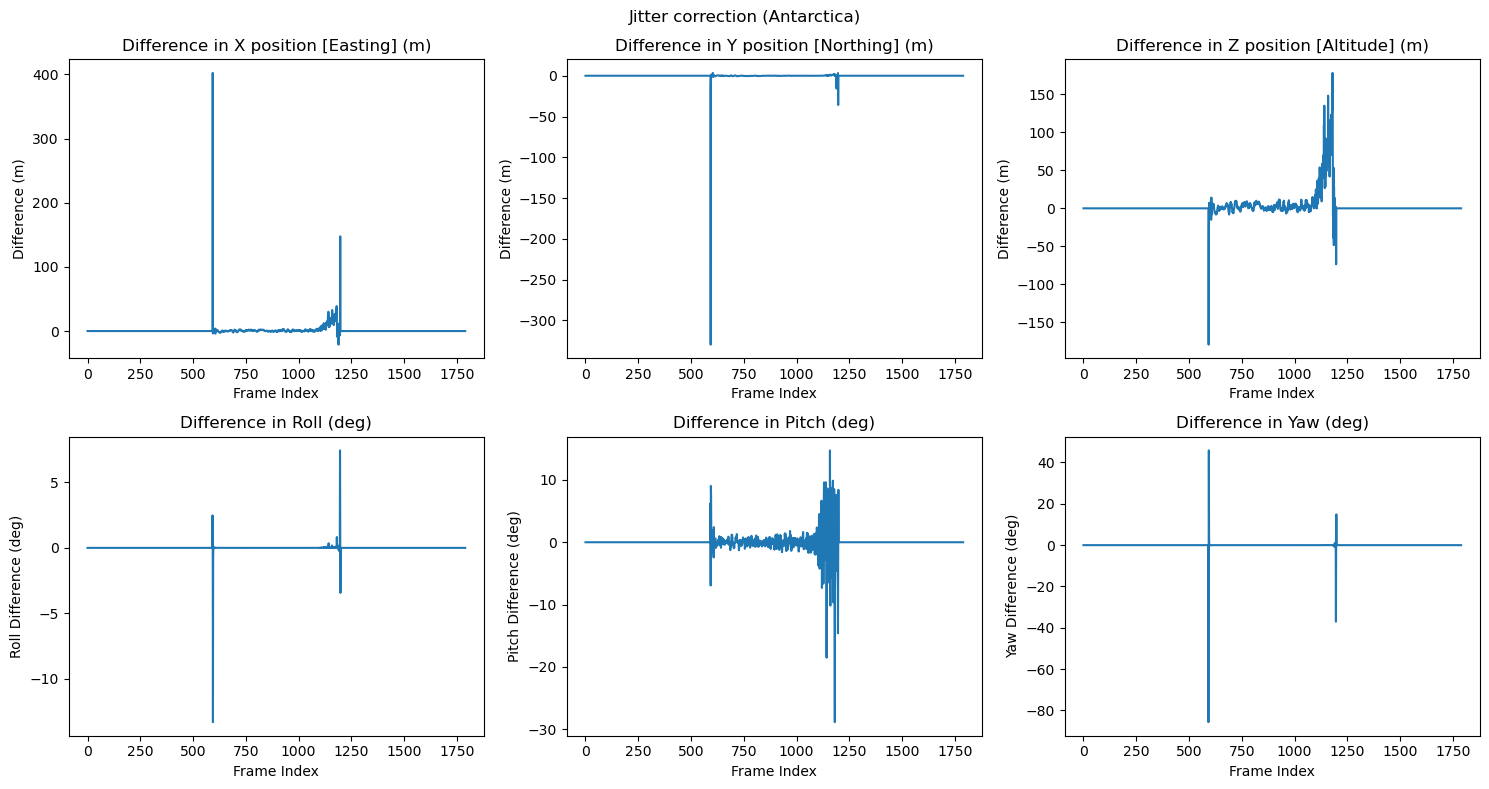

In [5]:
map_crs = "32728" # UTM 28S
title = "Jitter correction (Antarctica)"

original_camera = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"

# alternative, second set of camera files:
# original_camera = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
# optimized_camera = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# Get the GeoDataFrame for plotting
gdf = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs)

# Plot the original and optimized angles
mapview_original_optimized_angles(gdf, title=title, **ctx_kwargs)
mapview_difference_in_positions_and_angles(gdf, title=title, **ctx_kwargs)
plot_difference_in_positions_and_angles(gdf, title=title)

## Bundle adjust optimization for Utqiagvik

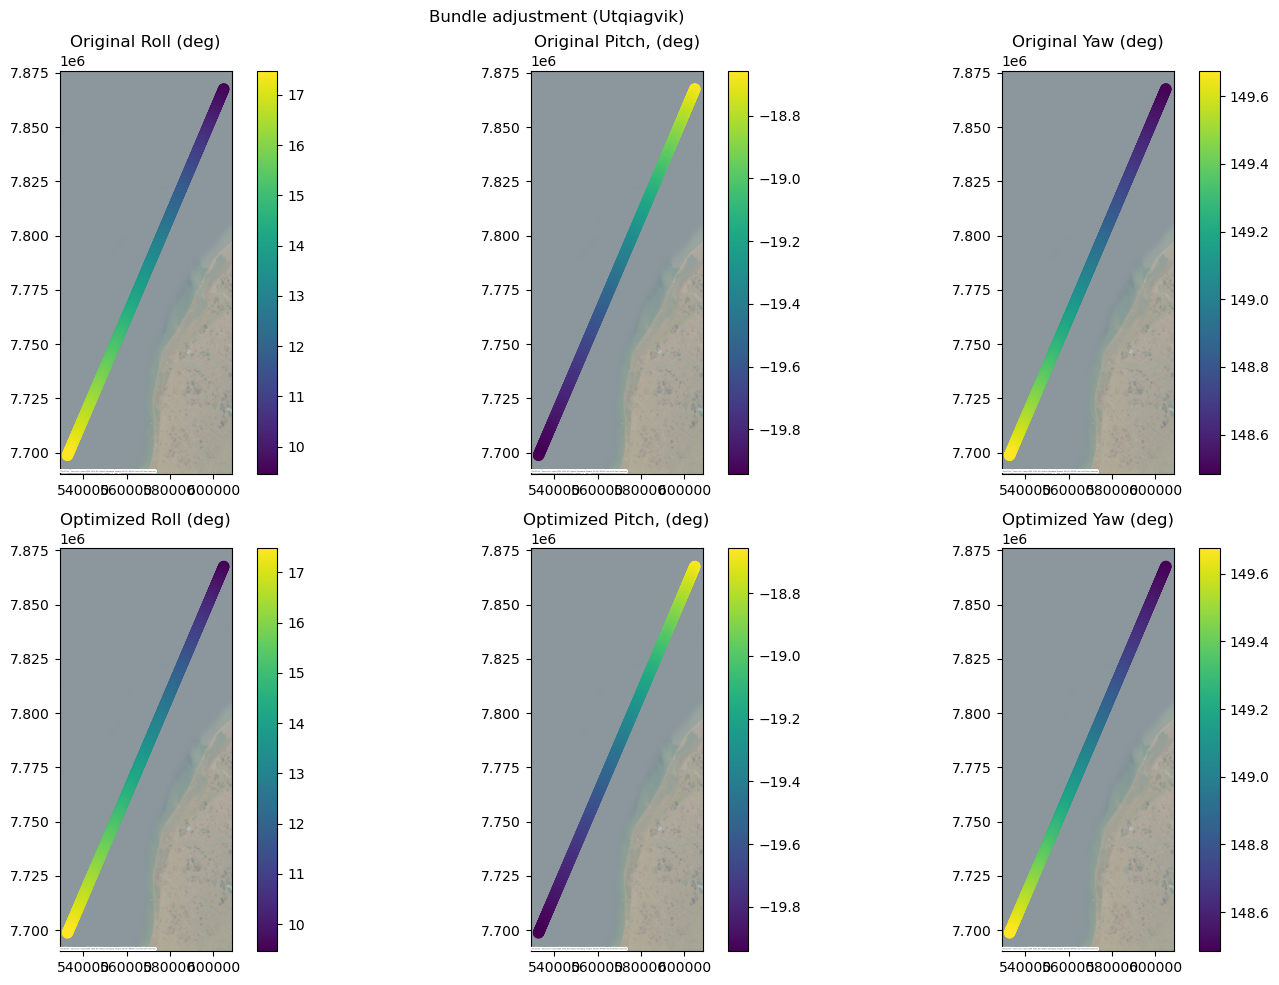

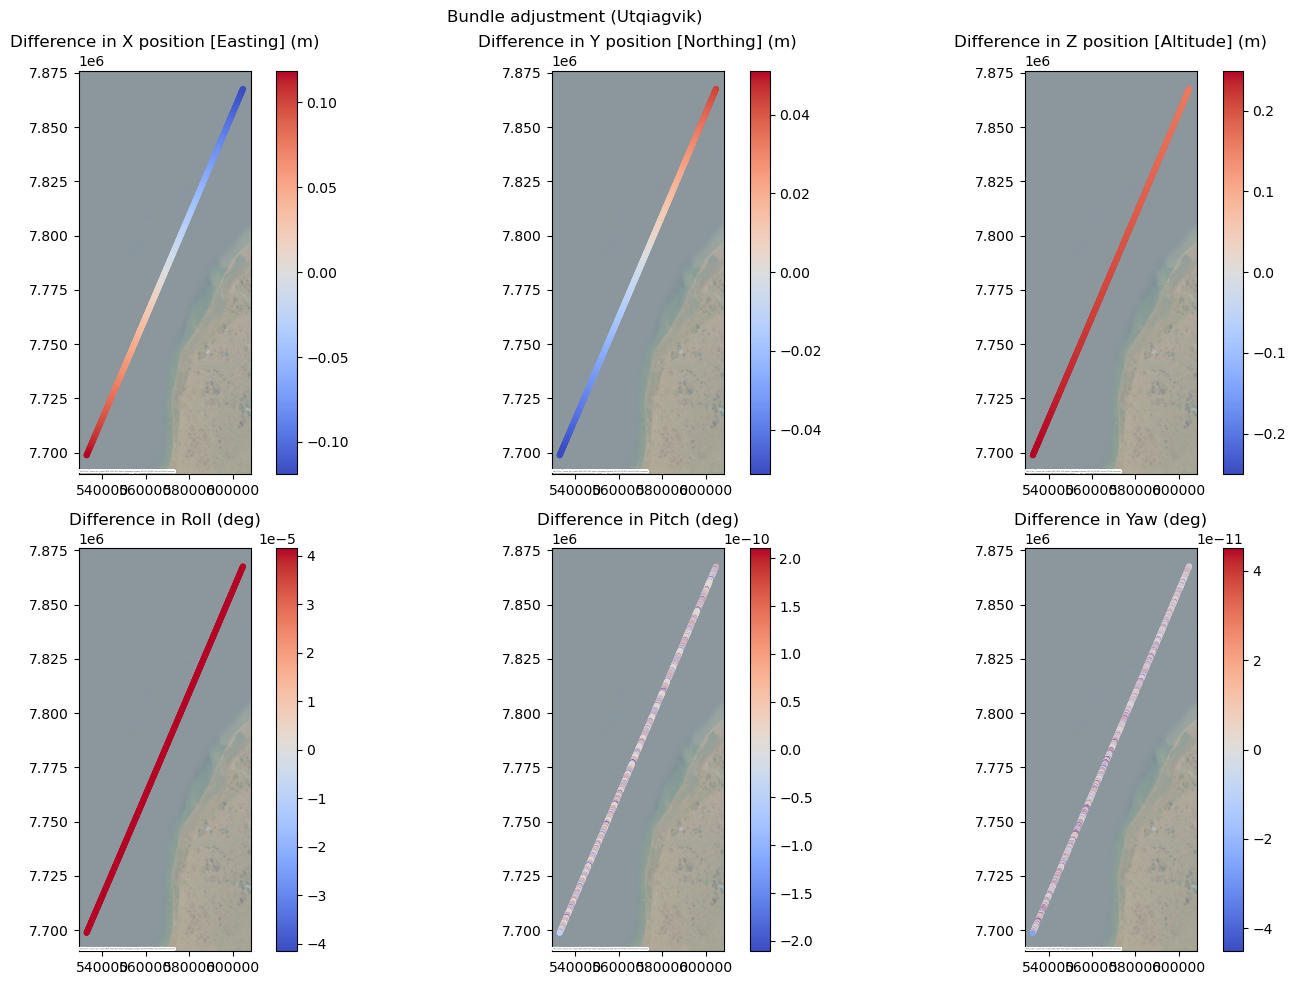

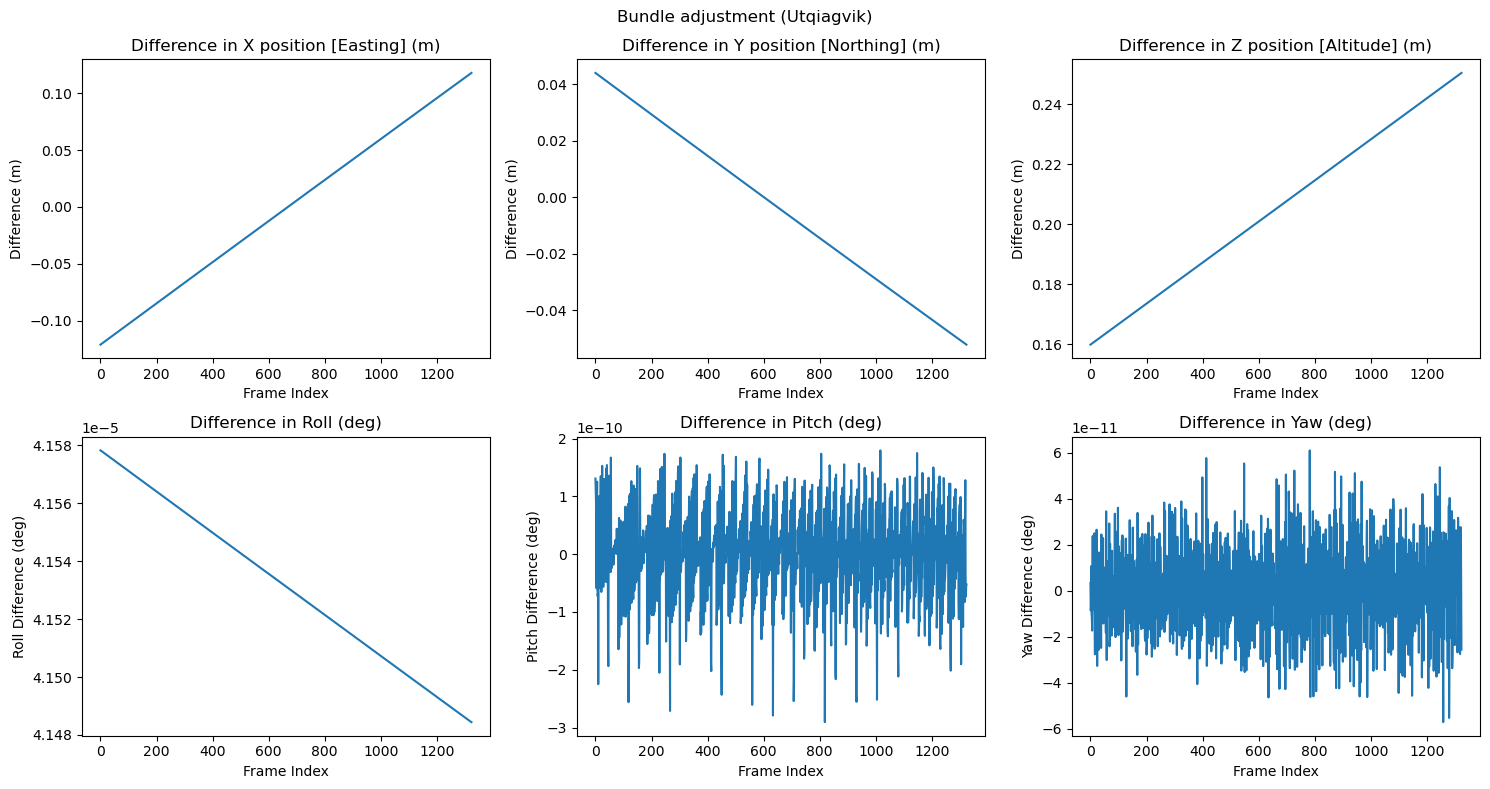

In [6]:
map_crs = "32603" # UTM 3N
title = "Bundle adjustment (Utqiagvik)"

# ba (utqiagvik)
original_camera = "../tests/test_data/ba_cams/1040010075633C00.json"
optimized_camera = "../tests/test_data/ba_cams/1040010075633C00.adjusted_state.json"

# alternative, second set of camera files:
# original_camera = "../tests/test_data/ba_cams/1040010074793300.json"
# optimized_camera = "../tests/test_data/ba_cams/1040010074793300.adjusted_state.json"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# Get the GeoDataFrame for plotting
gdf = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs)

# Plot the original and optimized angles
mapview_original_optimized_angles(gdf, title=title, figsize=(15, 10), **ctx_kwargs)
mapview_difference_in_positions_and_angles(gdf, title=title, figsize=(15, 10), **ctx_kwargs)
plot_difference_in_positions_and_angles(gdf, title=title)